In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import re
import gender_guesser.detector as gender

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from ydata_profiling import ProfileReport # подробный разбор признаков

In [2]:
data_patch = '.\\'

In [5]:
pd.read_csv(data_patch + 'train.csv')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [8]:
def preprocessing_data(filename, dummies=False, polynomial=False, test=False):
    
    dataframe = pd.read_csv(filename).copy()
    if test:
        dataframe['PassengerId'].to_csv('sample_submission.csv', sep=',', index=False)
    else:
        dataframe['Transported'] = dataframe['Transported'].map({True:1,False:0})
        transported = dataframe['Transported']
        dataframe = dataframe.drop(['Transported'], axis=1)
                    
    mask = dataframe['Age'].isna()
    dataframe.loc[mask, 'Age'] = np.random.randint(10, 50, mask.sum())
    dataframe['Cabin'] = dataframe['Cabin'].fillna(dataframe['Cabin'].mode()[0])
    dataframe['PassengerId'] = dataframe['PassengerId'].apply(lambda x: str(x).split('_')[0])
    dataframe['Name'] = dataframe['Name'].fillna(dataframe['Name'].mode()[0])
    dataframe['Surname'] = dataframe['Name'].apply(lambda x: str(x).split(' ')[1])
                
    for i, col in enumerate(['Cabin_deck', 'Cabin_num', 'Cabin_side']):
        dataframe[col] = dataframe['Cabin'].apply(lambda x: str(x).split('/')[i])
    
    for col in ['PassengerId', 'Cabin_deck', 'Cabin_side', 'Surname', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
        for i, x in enumerate(list(dataframe[col].value_counts(ascending = True).index[:])):
            dataframe[col] = dataframe[col].replace(x, (i+1))
        
    # for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    #     dataframe[col] = dataframe[col].apply(lambda x: 1 if x!=0 else 0)
    
    dataframe = dataframe.drop(['Cabin', 'Cabin_num', 'Name'], axis=1)
    
    for col in dataframe.columns:
        modde = dataframe[col].mode()[0]
        dataframe[col] = dataframe[col].fillna(modde)
        a = dataframe[col].unique()
        if col in ['HomePlanet', 'Destination']:
            b = [1, 2, 3]
            dataframe[col] = dataframe[col].replace(list(set(a).symmetric_difference(b)), modde)
        elif col in ['CryoSleep', 'VIP']:
            b = [1, 0]
            dataframe[col] = dataframe[col].replace(list(set(a).symmetric_difference(b)), modde)
        
    if dummies:
        dataframe = pd.get_dummies(dataframe, columns=['HomePlanet', 'Destination'], dtype=int)
    
    if polynomial:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        dataframe = poly.fit_transform(dataframe)
            
    #dataframe = RobustScaler().fit_transform(dataframe)
    #dataframe = MinMaxScaler().fit_transform(dataframe)
    data_scaled = pd.DataFrame(data=dataframe)
    
    if test:        
        return data_scaled
    else:
        X_train, X_val, y_train, y_val = train_test_split(data_scaled, transported, test_size=0.2, random_state=2, stratify=transported)
        return X_train, X_val, y_train, y_val

In [35]:
preprocessing_data(data_patch + 'train.csv', test=True).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.5,1.0,1.0,0.493671,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.571429,0.0
1,0.675515,1.0,1.0,1.0,0.303797,1.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.655235,1.000000,1.0
2,0.782497,0.5,1.0,1.0,0.734177,0.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,0.796931,0.142857,1.0
3,0.782497,0.5,1.0,1.0,0.417722,1.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,0.796931,0.142857,1.0
4,0.674228,1.0,1.0,1.0,0.202532,1.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.787906,1.000000,1.0


In [4]:
def tab_models_score(name_model, model, plot_score, dumm=False, polynomi=False, grids=False):
               
    if dumm == True and polynomi == True:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv', dummies=True, polynomial=True)
    elif dumm == True and polynomi == False:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv', dummies=True)
    elif dumm == False and polynomi == True:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv', polynomial=True)
    else:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv')
    model.fit(X_train, y_train)
    train_list = classification_report(y_train, model.predict(X_train))
    val_list = classification_report(y_val, model.predict(X_val))
    score_train = train_list.split(' ')[126]
    score_val = val_list.split(' ')[128]
    plot_score.loc[len(plot_score)] = [str(name_model), score_train, score_val]
    
    if grids:
        print("Наилучшие значения параметров: {}".format(model.best_params_))
        print("Наилучшее значение кросс-валидац. правильности: {:.2f}".format(model.best_score_))       

In [5]:
plot_score_train = pd.DataFrame(columns=['model', 'train', 'val'])
plot_score_dummies = pd.DataFrame(columns=['model', 'train', 'val'])
plot_score_polynomial = pd.DataFrame(columns=['model', 'train', 'val'])
plot_score_all = pd.DataFrame(columns=['model', 'train', 'val'])

In [12]:
pd.read_csv(data_patch + 'train.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<div style="font-size: 30px">
БЕЗ get_dummies, PolynomialFeatures, GridSearchCV

In [18]:
logreg = LogisticRegression(max_iter=500, random_state=2)
tab_models_score('LogisticRegression', logreg, plot_score_train) 

knn = KNeighborsClassifier(n_neighbors=3)
tab_models_score('KNeighborsClassifier_3', knn, plot_score_train)

knn = KNeighborsClassifier(n_neighbors=5)
tab_models_score('KNeighborsClassifier_5', knn, plot_score_train)

dtc = DecisionTreeClassifier(max_depth=5, random_state=2)
tab_models_score('DecisionTreeClassifier', dtc, plot_score_train)

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=2)
tab_models_score('RandomForestClassifier', rfc, plot_score_train)

gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_train)

svc = SVC(random_state=2)
tab_models_score('SVC', svc, plot_score_train)

mlp = MLPClassifier(max_iter=2100, hidden_layer_sizes=[30, 50, 10], random_state=2)
tab_models_score('MLPClassifier', mlp, plot_score_train)

light = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, seed=2, verbosity=-1)
tab_models_score('LGBMClassifier', light, plot_score_train)

X_GB = XGBClassifier(objective='binary:logistic')
tab_models_score('XGBClassifier', X_GB, plot_score_train)

cat = CatBoostClassifier(verbose=False)
tab_models_score('CatBoostClassifier', cat, plot_score_train)

display(plot_score_train)

,model,train,val
0,LogisticRegression,0.76,0.76
1,KNeighborsClassifier_3,0.85,0.72
2,KNeighborsClassifier_5,0.81,0.72
3,DecisionTreeClassifier,0.78,0.78
4,RandomForestClassifier,0.79,0.79
5,GradientBoostingClassifier,0.82,0.80
6,SVC,0.76,0.76
7,MLPClassifier,0.81,0.81
8,LGBMClassifier,0.82,0.81
9,XGBClassifier,0.95,0.80


<div style="font-size: 30px">
C get_dummies

In [20]:
logreg = LogisticRegression(max_iter=500, random_state=2)
tab_models_score('LogisticRegression', logreg, plot_score_dummies, dumm=True) 

knn = KNeighborsClassifier(n_neighbors=3)
tab_models_score('KNeighborsClassifier_3', knn, plot_score_dummies, dumm=True)

knn = KNeighborsClassifier(n_neighbors=5)
tab_models_score('KNeighborsClassifier_5', knn, plot_score_dummies, dumm=True)

dtc = DecisionTreeClassifier(max_depth=5, random_state=2)
tab_models_score('DecisionTreeClassifier', dtc, plot_score_dummies, dumm=True)

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=2)
tab_models_score('RandomForestClassifier', rfc, plot_score_dummies, dumm=True)

gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_dummies, dumm=True)

svc = SVC(random_state=2)
tab_models_score('SVC', svc, plot_score_dummies, dumm=True)

mlp = MLPClassifier(max_iter=2100, hidden_layer_sizes=[30, 50, 10], random_state=2)
tab_models_score('MLPClassifier', mlp, plot_score_dummies, dumm=True)

light = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, seed=2, verbosity=-1)
tab_models_score('LGBMClassifier', light, plot_score_dummies, dumm=True)

X_GB = XGBClassifier(objective='binary:logistic')
tab_models_score('XGBClassifier', X_GB, plot_score_dummies, dumm=True)

cat = CatBoostClassifier(verbose=False)
tab_models_score('CatBoostClassifier', cat, plot_score_dummies, dumm=True)

display(plot_score_dummies)

,model,train,val
0,LogisticRegression,0.79,0.80
1,KNeighborsClassifier_3,0.87,0.78
2,KNeighborsClassifier_5,0.84,0.79
3,DecisionTreeClassifier,0.78,0.78
4,RandomForestClassifier,0.79,0.78
5,GradientBoostingClassifier,0.82,0.81
6,SVC,0.79,0.80
7,MLPClassifier,0.84,0.79
8,LGBMClassifier,0.82,0.81
9,XGBClassifier,0.93,0.81


<div style="font-size: 30px">
C PolynomialFeatures

In [15]:
logreg = LogisticRegression(max_iter=1000, random_state=2)
tab_models_score('LogisticRegression', logreg, plot_score_polynomial, polynomi=True) 

knn = KNeighborsClassifier(n_neighbors=3)
tab_models_score('KNeighborsClassifier_3', knn, plot_score_polynomial, polynomi=True)

knn = KNeighborsClassifier(n_neighbors=5)
tab_models_score('KNeighborsClassifier_5', knn, plot_score_polynomial, polynomi=True)

dtc = DecisionTreeClassifier(max_depth=5, random_state=2)
tab_models_score('DecisionTreeClassifier', dtc, plot_score_polynomial, polynomi=True)

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=2)
tab_models_score('RandomForestClassifier', rfc, plot_score_polynomial, polynomi=True)

gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_polynomial, polynomi=True)

svc = SVC(random_state=2)
tab_models_score('SVC', svc, plot_score_polynomial, polynomi=True)

mlp = MLPClassifier(max_iter=2100, hidden_layer_sizes=[30, 50, 10], random_state=2)
tab_models_score('MLPClassifier', mlp, plot_score_polynomial, polynomi=True)

light = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, seed=2, verbosity=-1)
tab_models_score('LGBMClassifier', light, plot_score_polynomial, polynomi=True)

X_GB = XGBClassifier(objective='binary:logistic')
tab_models_score('XGBClassifier', X_GB, plot_score_polynomial, polynomi=True)

cat = CatBoostClassifier(verbose=False)
tab_models_score('CatBoostClassifier', cat, plot_score_polynomial, polynomi=True)

display(plot_score_polynomial)

,model,train,val
0,LogisticRegression,0.80,0.80
1,KNeighborsClassifier_3,0.86,0.73
2,KNeighborsClassifier_5,0.83,0.74
3,DecisionTreeClassifier,0.78,0.77
4,RandomForestClassifier,0.80,0.79
5,GradientBoostingClassifier,0.83,0.81
6,SVC,0.77,0.77
7,MLPClassifier,0.82,0.80
8,LGBMClassifier,0.82,0.81
9,XGBClassifier,0.96,0.79


<div style="font-size: 30px">
C get_dummies, PolynomialFeatures, GridSearchCV

In [46]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2)

In [66]:
param_grid = [{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs']},
              {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cholesky']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['sag']},
              {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0, 0.01, 0.1, 1]}
             ]

gs_lr = GridSearchCV(LogisticRegression(max_iter=50, random_state=2), param_grid, error_score=0.5, cv=skf, n_jobs=3)
tab_models_score('LogisticRegression', gs_lr, plot_score_all, dumm=True)

In [67]:
param_grid = {'n_neighbors': [3, 5],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 50]}

gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid, error_score=0.5, cv=skf, n_jobs=3)
tab_models_score('KNeighborsClassifier', gs_knn, plot_score_all, dumm=True)

In [68]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_depth': [3, 5, 7], 
              'max_features': ['sqrt', 'log2']}

gs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('DecisionTreeClassifier', gs_dtc, plot_score_all, dumm=True)

In [49]:
param_grid = {'n_estimators': [10, 20, 50, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_depth': [3, 5, 7, 10], 
              'max_features': [3, 5, 7]}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('RandomForestClassifier', gs_rf, plot_score_all, grids=True)

KeyboardInterrupt: 

In [48]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [150, 200],
               'criterion': ['friedman_mse', 'squared_error'],
               'max_depth': [2, 3, 4],
               'loss': ['log_loss', 'exponential']}

gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('GradientBoostingClassifier', gs_gb, plot_score_all, grids=True)

In [71]:
param_grid = {'gamma': [0.09, 0.099, 0.1, 0.11, 0.12],
               'C': [5, 8, 9, 10, 12]}

gs_svc = GridSearchCV(SVC(random_state=2), param_grid, cv=5, n_jobs=3)
tab_models_score('SVC', gs_svc, plot_score_all, dumm=True)

In [72]:
param_grid = {'hidden_layer_sizes': [[20, 50, 10], [30, 60, 15], [10, 20, 5]],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam']}

mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=2), param_grid, cv=5, n_jobs=3)
tab_models_score('MLPClassifier', mlp, plot_score_all, dumm=True)

In [73]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1],
               'n_estimators': [100, 150],
               'max_depth': [2, 3, 4],
               'loss': ['regression', 'cross_entropy']}

gs_lgb = GridSearchCV(LGBMClassifier(random_state=2, verbosity=-1), param_grid, cv=skf, n_jobs=3)
tab_models_score('LGBMClassifier', gs_lgb, plot_score_all, dumm=True)

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


In [74]:
param_grid = {'learning_rate': [0.01, 0.1, 0.3],
               'max_depth': [2, 3, 4],
               'tree_method': ['auto', 'approx']}

gs_xgb = GridSearchCV(XGBClassifier(random_state=2, objective='binary:logistic'), param_grid, cv=skf, n_jobs=3)
tab_models_score('XGBClassifier', gs_xgb, plot_score_all, dumm=True)

In [75]:
param_grid = {'learning_rate': [0.01, 0.1, 0.3],
               'iterations': [50, 100, 150],
               'max_depth': [3, 4, 6]}

gs_cat = GridSearchCV(CatBoostClassifier(random_state=2, verbose=False), param_grid, cv=skf, n_jobs=3)
tab_models_score('CatBoostClassifier', gs_cat, plot_score_all, dumm=True)

In [76]:
display(plot_score_all)

,model,train,val
0,LogisticRegression,0.79,0.80
1,KNeighborsClassifier,0.83,0.78
2,DecisionTreeClassifier,0.77,0.75
3,RandomForestClassifier,0.85,0.81
4,GradientBoostingClassifier,0.80,0.80
5,SVC,0.88,0.76
6,MLPClassifier,0.81,0.81
7,LGBMClassifier,0.82,0.81
8,XGBClassifier,0.83,0.81
9,CatBoostClassifier,0.83,0.81


In [24]:
plot_score_1.to_csv('train_val_data_1.csv', sep=',', index=False)
plot_score_2.to_csv('train_val_data_2.csv', sep=',', index=False)

In [2]:
plot_score_1 = pd.read_csv('train_val_data_1.csv', sep=',')
plot_score_2 = pd.read_csv('train_val_data_2.csv', sep=',')

In [3]:
plot_score_1['model'] =plot_score_1['model'].astype(str)
plot_score_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   11 non-null     object 
 1   train   11 non-null     float64
 2   val     11 non-null     float64
dtypes: float64(2), object(1)
memory usage: 396.0+ bytes


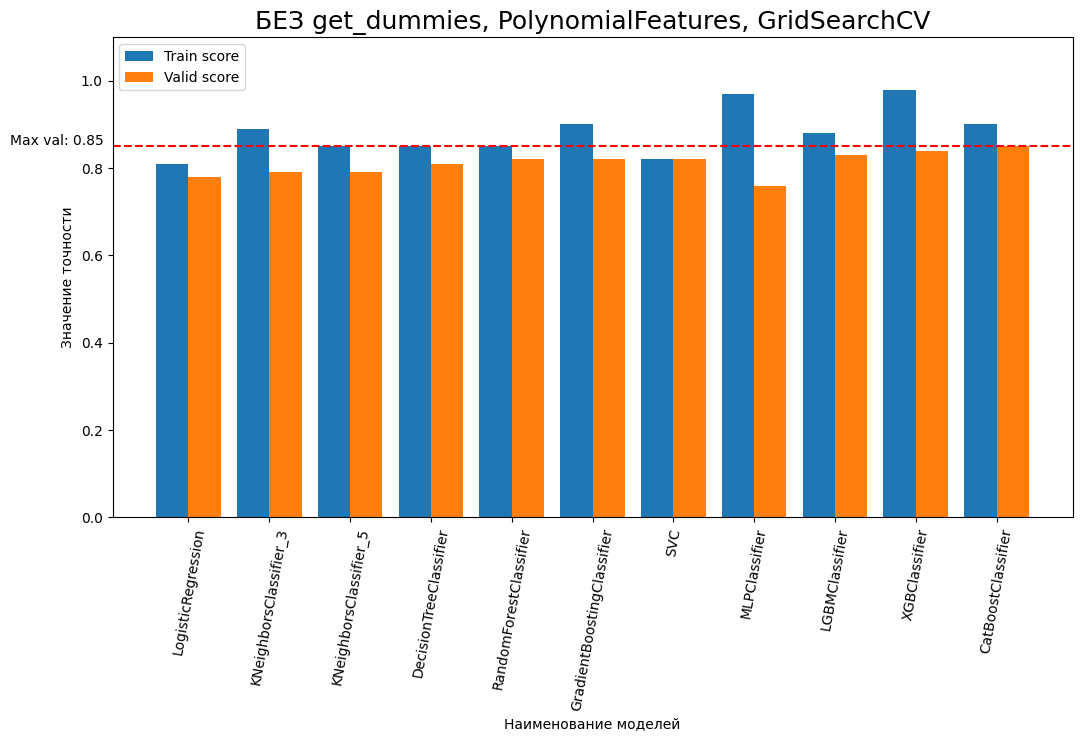

In [60]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 1]) # переменная - график
axes.bar(x = plot_score_1['model'], height = plot_score_1['train'],
        width = -0.4, align = 'edge', label = 'Train score')
axes.bar(x = plot_score_1['model'], height = plot_score_1['val'],
         width = 0.4, align = 'edge', label = 'Valid score')
# Добавляем линию на уровне максимального значения
max_value = np.max(plot_score_1['val'])
plt.axhline(y=max_value, color='r', linestyle='--')
# Добавляем текст с максимальным значением
axes.text(0, max_value-0.08, f"Max val: {max_value:.2f}  ", ha='right', va='bottom', transform=axes.transAxes)
axes.set_ylim(0, 1.1)
axes.legend(loc = 2)
plt.xticks(rotation=80)
plt.title('БЕЗ get_dummies, PolynomialFeatures, GridSearchCV', fontsize=18)
plt.xlabel('Наименование моделей') #Подпись для оси х
plt.ylabel('Значение точности') #Подпись для оси y
plt.legend(loc=2)
plt.show()

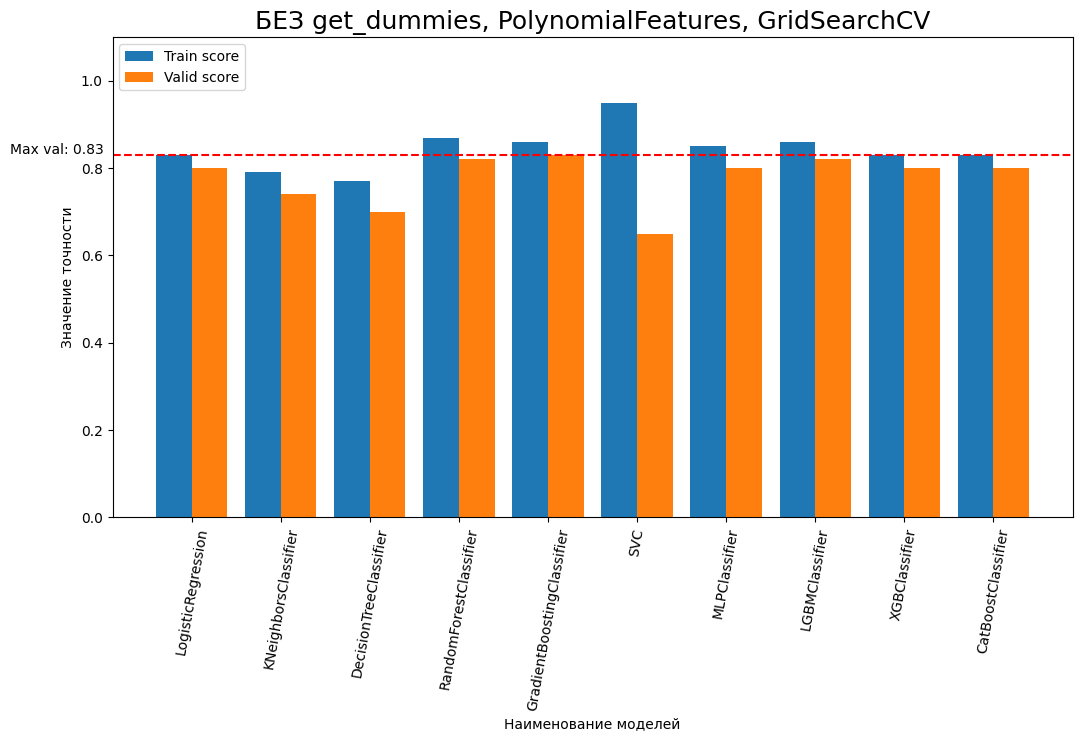

In [59]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 1]) # переменная - график
axes.bar(x = plot_score_2['model'], height = plot_score_2['train'],
        width = -0.4, align = 'edge', label = 'Train score')
axes.bar(x = plot_score_2['model'], height = plot_score_2['val'],
         width = 0.4, align = 'edge', label = 'Valid score')
# Добавляем линию на уровне максимального значения
max_value = np.max(plot_score_2['val'])
plt.axhline(y=max_value, color='r', linestyle='--')
axes.text(0, max_value-0.08, f"Max val: {max_value:.2f}  ", ha='right', va='bottom', transform=axes.transAxes)
axes.set_ylim(0, 1.1)
axes.legend(loc = 2)
plt.xticks(rotation=80)
plt.title('БЕЗ get_dummies, PolynomialFeatures, GridSearchCV', fontsize=18)
plt.xlabel('Наименование моделей') #Подпись для оси х
plt.ylabel('Значение точности') #Подпись для оси y
plt.legend(loc=2)
plt.show()

In [25]:
cat = CatBoostClassifier(verbose=False)
tab_models_score('CatBoostClassifier', cat, plot_score_all)
X_test = preprocessing_data(data_patch + 'test.csv', test=True)
data = pd.read_csv('sample_submission.csv', sep=',')
data['Transported'] = cat.predict(X_test)
data['Transported'] = data['Transported'].astype(bool)
data.to_csv('sample_submission.csv', sep=',', index=False)

In [22]:
plot_score_all

,model,train,val
0,CatBoostClassifier,0.88,0.81


In [26]:
pd.read_csv('sample_submission.csv', sep=',')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [37]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2)
param_grid = {'n_estimators': [50, 100, 150, 200], 
              'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_depth': [7, 10, 12, 15], 
              'max_features': [4, 5, 6],
              'min_samples_split': [2, 3]}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('RandomForestClassifier', gs_rf, plot_score_all, grids=True)

Наилучшие значения параметров: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 150}
Наилучшее значение кросс-валидац. правильности: 0.80


In [30]:
param_grid = {'learning_rate': [0.001, 0.01, 0.05],
               'n_estimators': [150, 200],
               'criterion': ['friedman_mse', 'squared_error'],
               'max_depth': [2, 3, 4],
               'loss': ['log_loss', 'exponential']}

gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('GradientBoostingClassifier', gs_gb, plot_score_all, grids=True)

Наилучшие значения параметров: {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 4, 'n_estimators': 200}
Наилучшее значение кросс-валидац. правильности: 0.80


In [38]:
rfc = RandomForestClassifier(criterion='entropy', max_features=4, max_depth=12, min_samples_split=3, n_estimators=150, random_state=2) #0.78816
tab_models_score('RandomForestClassifier', rfc, plot_score_polynomial)
X_test = preprocessing_data(data_patch + 'test.csv', test=True)
data = pd.read_csv('sample_submission.csv', sep=',')
data['Transported'] = rfc.predict(X_test)
data['Transported'] = data['Transported'].apply(lambda x: bool(x))
data.to_csv('sample_submission.csv', sep=',', index=False)

In [32]:
gbc = GradientBoostingClassifier(criterion='friedman_mse', n_estimators=200, max_depth=4, learning_rate=0.06, random_state=2) #0.77624
tab_models_score('GradientBoostingClassifier', gbc, plot_score_train)
X_test = preprocessing_data(data_patch + 'test.csv', test=True)
data = pd.read_csv('sample_submission.csv', sep=',')
data['Transported'] = gbc.predict(X_test)
data['Transported'] = data['Transported'].apply(lambda x: bool(x))
data.to_csv('sample_submission.csv', sep=',', index=False)

In [10]:
from sklearn.pipeline import Pipeline

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2)
pipe = Pipeline([('preprocessing', [RobustScaler(), MinMaxScaler()]), ('classifier', GradientBoostingClassifier(random_state=2))])

param_grid = [
    {'classifier': [SVC()],
     'preprocessing': [RobustScaler(), MinMaxScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [GradientBoostingClassifier(random_state=2)],
     'preprocessing': [RobustScaler(), MinMaxScaler()],
     'classifier__learning_rate': [0.01, 0.05],
     'classifier__n_estimators': [150, 200],
     'classifier__max_depth': [2, 3, 4]}]

gs_gb = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=3)

tab_models_score('GradientBoostingClassifier', gs_gb, plot_score_all, grids=True)

Наилучшие значения параметров: {'classifier': GradientBoostingClassifier(random_state=2), 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 150, 'preprocessing': MinMaxScaler()}
Наилучшее значение кросс-валидац. правильности: 0.80
